In [1]:
import pandas as pd
from transformers import AutoTokenizer

/u/home/rodr/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./data/NOTEEVENTS.csv")
df_procedures_icd = pd.read_csv("./data/PROCEDURES_ICD.csv")
df_diagnoses_icd = pd.read_csv("./data/DIAGNOSES_ICD.csv")

df.dropna(subset="TEXT", inplace=True)
df_procedures_icd.dropna(subset="ICD9_CODE", inplace=True)
df_diagnoses_icd.dropna(subset="ICD9_CODE", inplace=True)

/tmp/ipykernel_464502/2122350042.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/NOTEEVENTS.csv")


In [3]:
def reformat(code, is_diag):
    """
        Put a period in the right place because the MIMIC-3 data files exclude them.
        Generally, procedure codes have dots after the first two digits, 
        while diagnosis codes have dots after the first three digits.
    """
    code = ''.join(str(code).split('.'))
    if is_diag:
        if code.startswith('E'):
            if len(code) > 4:
                code = code[:4] + '.' + code[4:]
        else:
            if len(code) > 3:
                code = code[:3] + '.' + code[3:]
    else:
        code = code[:2] + '.' + code[2:]
    code = code.strip(".")
    return code

In [4]:
df_procedures_icd["ICD9_CODE"] = df_procedures_icd["ICD9_CODE"].apply(reformat, is_diag=False)
df_diagnoses_icd["ICD9_CODE"] = df_diagnoses_icd["ICD9_CODE"].apply(reformat, is_diag=True)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
def tokenize_function(text):
    tokenizer_dict = tokenizer(text)
    return tokenizer_dict["input_ids"]

In [7]:
df = df[df["CATEGORY"]=="Discharge summary"]

df["TEXT"] = df.groupby("HADM_ID", as_index=False)["TEXT"].transform(lambda x: ' '.join(x))
df.drop_duplicates("HADM_ID", inplace=True)
df["TOKENS"] = df["TEXT"].apply(tokenize_function)

In [29]:
df_icd = pd.concat([df_procedures_icd, df_diagnoses_icd])
df_icd = df_icd.merge(df[["HADM_ID"]], on="HADM_ID")

In [30]:
int2icd_all = df_icd.groupby("ICD9_CODE", as_index=False).count().sort_values("ICD9_CODE")["ICD9_CODE"].to_dict()
icd2int_all = {v:k for k,v in int2icd_all.items()}

int2icd_top50 = df_icd.groupby("ICD9_CODE", as_index=False).count().sort_values("HADM_ID", ascending=False)[:50].reset_index(drop=True)["ICD9_CODE"].to_dict()
icd2int_top50 = {v:k for k,v in int2icd_top50.items()}

int2icd_top100 = df_icd.groupby("ICD9_CODE", as_index=False).count().sort_values("HADM_ID", ascending=False)[:100].reset_index(drop=True)["ICD9_CODE"].to_dict()
icd2int_top100 = {v:k for k,v in int2icd_top100.items()}

In [32]:
df_icd_all = df_icd.groupby("HADM_ID", as_index=False)[["ICD9_CODE"]].agg(list)

df_icd_top50 = df_icd[df_icd["ICD9_CODE"].isin(int2icd_top50.values())].reset_index()
df_icd_top50 = df_icd_top50.groupby("HADM_ID", as_index=False)[["ICD9_CODE"]].agg(list)

df_icd_top100 = df_icd[df_icd["ICD9_CODE"].isin(int2icd_top100.values())].reset_index()
df_icd_top100 = df_icd_top100.groupby("HADM_ID", as_index=False)[["ICD9_CODE"]].agg(list)

In [41]:
df_all = df.merge(df_icd_all, on="HADM_ID", how="inner")
df_top50 = df.merge(df_icd_top50, on="HADM_ID", how="inner")
df_top100 = df.merge(df_icd_top100, on="HADM_ID", how="inner")

### Distribution of number of ICD9 codes per sample (using ALL ICD9 codes)

count    52722.000000
mean        16.097417
std          8.466425
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max         79.000000
Name: ICD9_CODE, dtype: float64

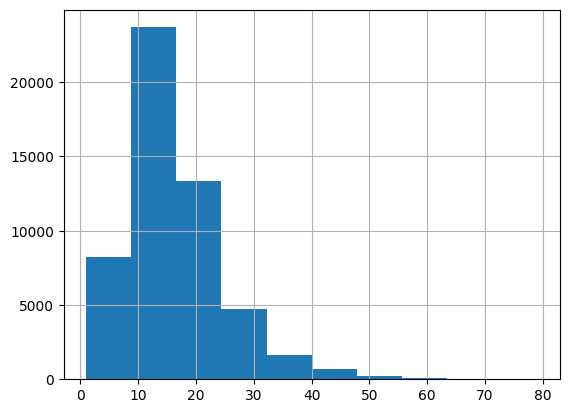

In [39]:
df_icd_all["ICD9_CODE"].str.len().hist()
df_icd_all["ICD9_CODE"].str.len().describe()

### Distribution of number of TOKENS per sample (using ALL ICD9 codes)

count    52722.000000
mean      2311.412427
std       1213.847974
min         44.000000
25%       1432.000000
50%       2113.000000
75%       2947.000000
max      15506.000000
Name: TOKENS, dtype: float64

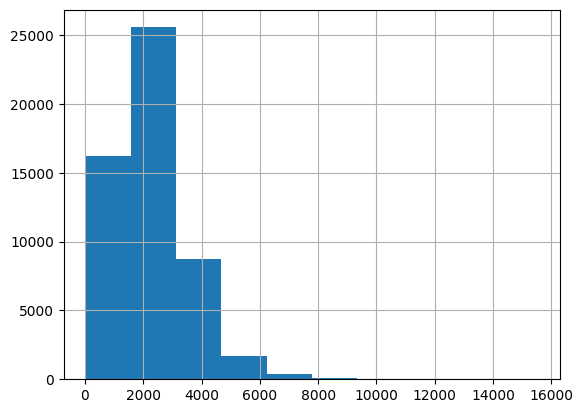

In [42]:
df_all["TOKENS"].str.len().hist()
df_all["TOKENS"].str.len().describe()

### Distribution of number of ICD9 codes per sample (using TOP 100 ICD9 codes)

count    49617.000000
mean         5.803072
std          3.435218
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         27.000000
Name: ICD9_CODE, dtype: float64

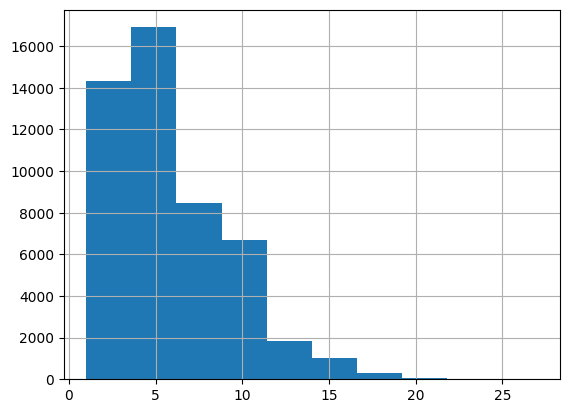

In [40]:
df_icd_top100["ICD9_CODE"].str.len().hist()
df_icd_top100["ICD9_CODE"].str.len().describe()

### Distribution of number of TOKENS per sample (using TOP 100 ICD9 codes)

count    51347.000000
mean      2332.595692
std       1215.997503
min         44.000000
25%       1454.000000
50%       2139.000000
75%       2969.000000
max      15506.000000
Name: TOKENS, dtype: float64

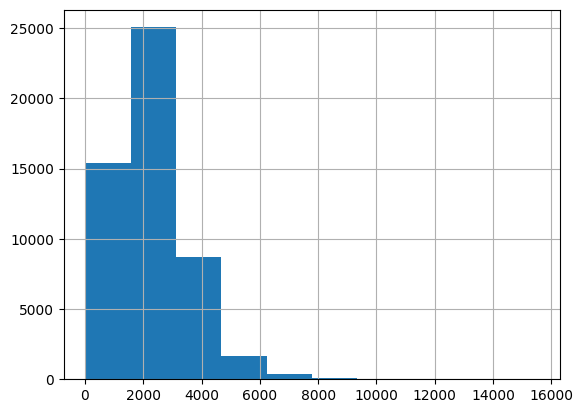

In [43]:
df_top100["TOKENS"].str.len().hist()
df_top100["TOKENS"].str.len().describe()

### Distribution of number of ICD9 codes per sample (using TOP 50 ICD9 codes)

count    49617.000000
mean         5.803072
std          3.435218
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         27.000000
Name: ICD9_CODE, dtype: float64

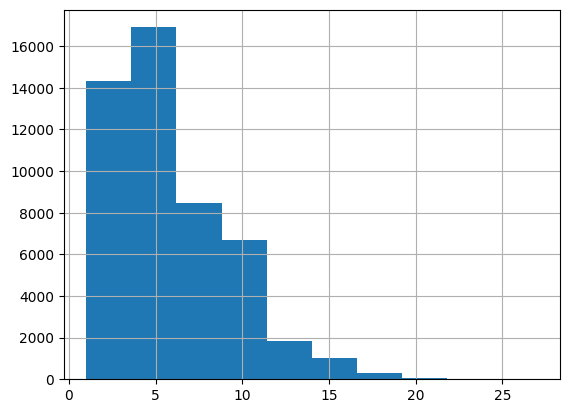

In [44]:
df_icd_top50["ICD9_CODE"].str.len().hist()
df_icd_top50["ICD9_CODE"].str.len().describe()

### Distribution of number of TOKENS per sample (using TOP 50 ICD9 codes)

count    49617.000000
mean      2367.917085
std       1213.468264
min         44.000000
25%       1500.000000
50%       2174.000000
75%       2999.000000
max      15506.000000
Name: TOKENS, dtype: float64

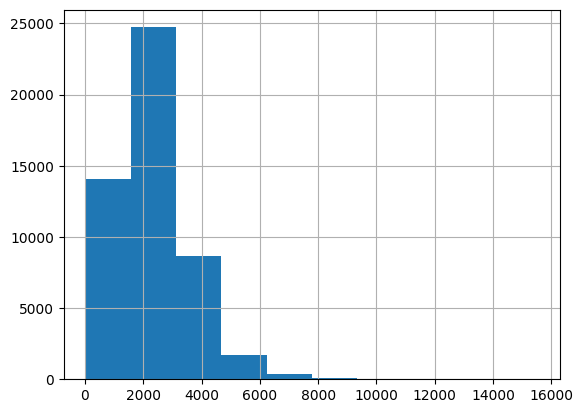

In [45]:
df_top50["TOKENS"].str.len().hist()
df_top50["TOKENS"].str.len().describe()